Why can't I have a SkyCoord object which has RA/Dec and Alt/Az info simultaneously?  It's so odd ...

In [15]:
import numpy as np
from astropy import constants as c
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import clear_output
rc('text', usetex=True)
rc('font', family='serif')
rc('font',size=16)

In [16]:
def progress_bar(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [17]:
# Define the reference time and location
mcmurdo = EarthLocation(lat='-77.8419', lon='166.6863', height=37000.)
time0 = Time('2019-12-15 18:00:00', scale='utc', location = mcmurdo)

In [18]:
# Define what a single scan looks like, centered on a given central pointing position
# (which could be a vector)
def AzScan(target, dt = np.power(488*units.Hz,-1)):
    return scan

In [19]:
dt = 0.9*u.second
times = time0 + np.arange(0,24,dt.to(u.hr).value)*u.hr
t_sec = ((times.jd-times.jd[0])*u.day).to(u.second)
t_hr= t_sec.to(u.hr)
print(times.shape)

(96000,)


In [20]:
az_scan_rate = 0.1*u.degree/(1.0*u.second)
az_scan_extent = 1.0*u.degree
az_scans = np.zeros_like(t_sec.value)*u.degree
az_scans[0] = -az_scan_extent/2.
scan_dir = 1
daz = az_scan_rate*dt

In [62]:
%%time
field_S = SkyCoord(ra=12*15.*u.degree,dec=-55*u.degree, 
                   obstime=times, location=mcmurdo)
# You can either have it in altaz, or in RA/Dec, but not both for some reason
field_S_altaz = field_S.transform_to('altaz')

CPU times: user 11.2 s, sys: 103 ms, total: 11.3 s
Wall time: 11 s


In [63]:
%%time
field_N = SkyCoord(ra=3.*15*u.degree,dec=-27*u.degree, 
                   obstime=times, location=mcmurdo)
field_N_altaz = field_N.transform_to('altaz')

CPU times: user 11.2 s, sys: 104 ms, total: 11.3 s
Wall time: 11 s


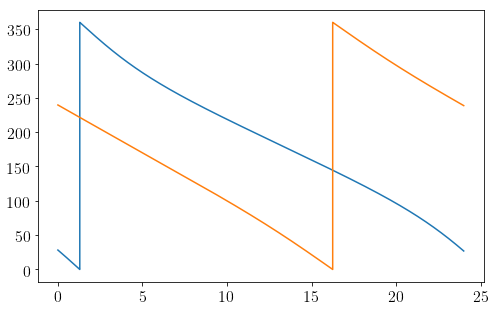

In [64]:
plt.figure(figsize=(8,5))
plt.plot(t_hr,field_S_altaz.az.deg)
plt.plot(t_hr,field_N_altaz.az.deg)
plt.show()

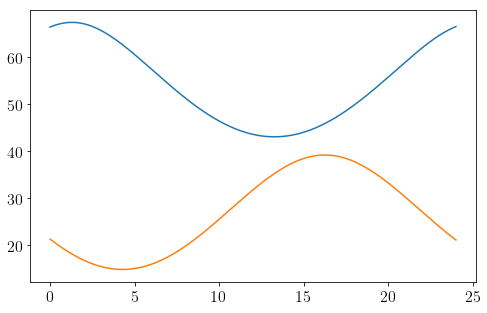

In [65]:
plt.figure(figsize=(8,5))
plt.plot(t_hr,field_S_altaz.alt.deg)
plt.plot(t_hr,field_N_altaz.alt.deg)
plt.show()

In [66]:
%%time
for i in np.arange(len(az_scans)-1):
    # if on the next step you would exceed the extent in the positive direction, reverse course
    if az_scans[i-1] > (az_scan_extent/2.-daz): 
        scan_dir = -1
    if az_scans[i-1] < (-az_scan_extent/2.+daz): 
        scan_dir = 1
    az_scans[i] = az_scans[i-1] + scan_dir*daz

CPU times: user 15.4 s, sys: 98.6 ms, total: 15.5 s
Wall time: 15.6 s


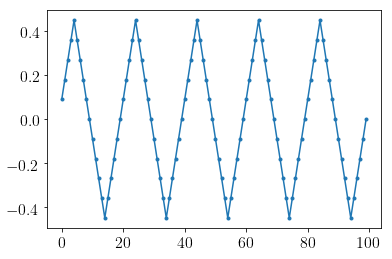

In [67]:
plt.plot(az_scans[0:100],'.-')

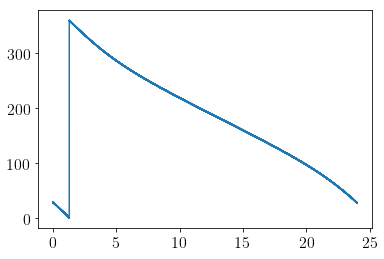

In [68]:
plt.plot(t_hr, field_S_altaz.az+az_scans)

In [70]:
def BuildPointing(field_altaz, field_radec, times, location, az_scans):
    pointing = SkyCoord(alt = field_altaz.alt, az = field_altaz.az+az_scans, 
                       frame='altaz', obstime = times, location = location)
    pointing_radec = pointing.transform_to('icrs') # the fuck? why can't I do this in place?
    ra_off = pointing_radec.ra - field_radec.ra
    dec_off = pointing_radec.dec - field_radec.dec
    
    return pointing, pointing_radec, ra_off, dec_off

In [71]:
%%time
pointing_S, pointing_S_radec, dra_S, ddec_S = BuildPointing(field_S_altaz, field_S, times, mcmurdo, az_scans)

CPU times: user 12.1 s, sys: 136 ms, total: 12.2 s
Wall time: 11.6 s


In [73]:
%%time
pointing_N, pointing_N_radec, dra_N, ddec_N = BuildPointing(field_N_altaz, field_N, times, mcmurdo, az_scans)

CPU times: user 12 s, sys: 107 ms, total: 12.1 s
Wall time: 11.4 s


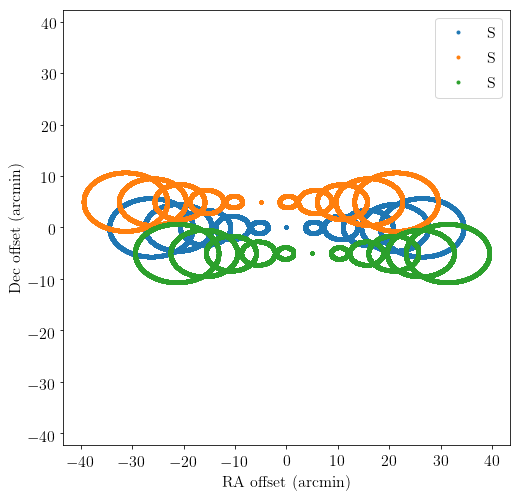

In [84]:
plt.figure(figsize=[8,8])
plt.plot(dra_S.to(units.arcmin), ddec_S.to(units.arcmin), '.', label='S')
plt.plot(dra_S.to(units.arcmin)-5.*u.arcmin, ddec_S.to(units.arcmin)+5.*u.arcmin, '.', label='S')
plt.plot(dra_S.to(units.arcmin)+5.*u.arcmin, ddec_S.to(units.arcmin)-5.*u.arcmin, '.', label='S')
#plt.plot(dra_N.to(units.arcmin)[0:100], ddec_N.to(units.arcmin)[0:100], '.', label='N')
plt.axis('equal')
plt.xlabel('RA offset (arcmin)')
plt.ylabel('Dec offset (arcmin)')
plt.legend()
plt.show()

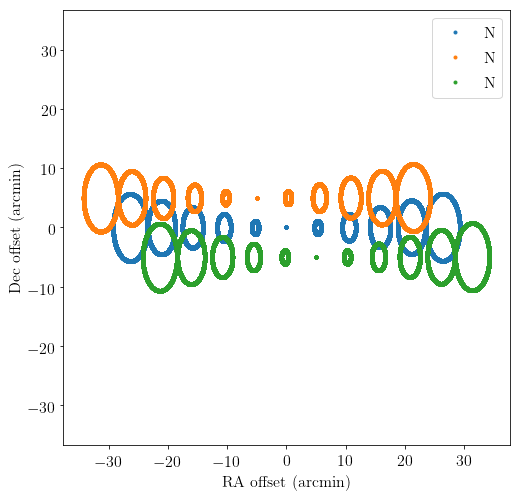

In [85]:
plt.figure(figsize=[8,8])
plt.plot(dra_N.to(units.arcmin), ddec_N.to(units.arcmin), '.', label='N')
plt.plot(dra_N.to(units.arcmin)-5.*u.arcmin, ddec_N.to(units.arcmin)+5.*u.arcmin, '.', label='N')
plt.plot(dra_N.to(units.arcmin)+5.*u.arcmin, ddec_N.to(units.arcmin)-5.*u.arcmin, '.', label='N')
#plt.plot(dra_N.to(units.arcmin)[0:100], ddec_N.to(units.arcmin)[0:100], '.', label='N')
plt.axis('equal')
plt.xlabel('RA offset (arcmin)')
plt.ylabel('Dec offset (arcmin)')
plt.legend()
plt.show()

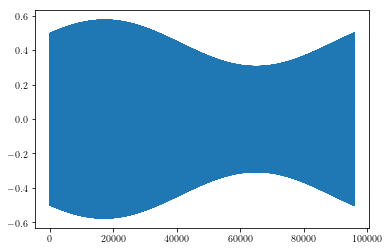

In [118]:
plt.plot(ra_off)